In [1]:
#Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from datetime import datetime
import locale
import warnings
warnings.filterwarnings("ignore", category=UserWarning, 
                        message="Boolean Series key will be reindexed to match DataFrame index")
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
#import dataset

OriData = pd.read_csv('documents/python/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv')

#Know your data

print(OriData.head(5))

#Drop columns those are not useful in the analysis
WorkData = OriData.drop(columns=['flag_allcause', 'flag_natcause',
       'flag_sept', 'flag_neopl', 'flag_diab', 'flag_alz', 'flag_inflpn',
       'flag_clrd', 'flag_otherresp', 'flag_nephr', 'flag_otherunk', 'flag_hd',
       'flag_stroke'])

#verify drop column
print(WorkData.head(5), end='\n\n')

print(f'There are total {len(WorkData)} observations for {len(WorkData.columns)} variables.')


  Jurisdiction of Occurrence  MMWR Year  MMWR Week Week Ending Date  \
0                    Florida       2014         43       10/25/2014   
1                    Florida       2014         44       11/01/2014   
2                    Florida       2014         45       11/08/2014   
3                    Florida       2014         46       11/15/2014   
4                    Florida       2014         47       11/22/2014   

   All  Cause  Natural Cause  Septicemia (A40-A41)  \
0        3381           3149                  38.0   
1        3501           3261                  43.0   
2        3646           3369                  44.0   
3        3615           3346                  43.0   
4        3672           3383                  39.0   

   Malignant neoplasms (C00-C97)  Diabetes mellitus (E10-E14)  \
0                          854.0                         81.0   
1                          859.0                         85.0   
2                          838.0                     

In [3]:
#EDA-1

#How many years' data
yearsdata = WorkData['MMWR Year'].unique()
print(tabulate([yearsdata], tablefmt='fancy_grid', showindex='never'), end='\n\n')


#How many unique years by states

N_states = WorkData['Jurisdiction of Occurrence'].nunique()

print(f'There are total {N_states} states.', end='\n\n')

print(WorkData.groupby('Jurisdiction of Occurrence')['MMWR Year'].nunique(), end='\n\n')


#We have all the 50 states, Washington D.C., and the USA deaths as well
#How many Null values

Tot_null = WorkData.isna().sum().reset_index()
NA_tbl = tabulate(Tot_null, headers=['column name','NA values'], showindex=False, tablefmt='fancy_grid')
print(NA_tbl)



╒══════╤══════╤══════╤══════╤══════╤══════╕
│ 2014 │ 2015 │ 2016 │ 2017 │ 2018 │ 2019 │
╘══════╧══════╧══════╧══════╧══════╧══════╛

There are total 54 states.

Jurisdiction of Occurrence
Alabama                 6
Alaska                  6
Arizona                 6
Arkansas                6
California              6
Colorado                6
Connecticut             6
Delaware                6
District of Columbia    6
Florida                 6
Georgia                 6
Hawaii                  6
Idaho                   6
Illinois                6
Indiana                 6
Iowa                    6
Kansas                  6
Kentucky                6
Louisiana               6
Maine                   6
Maryland                6
Massachusetts           6
Michigan                6
Minnesota               6
Mississippi             6
Missouri                6
Montana                 6
Nebraska                6
Nevada                  6
New Hampshire           6
New Jersey              6
New Me

In [4]:
#ETL-1

# Filter data for New York City and New York State
nyc_data = WorkData[WorkData['Jurisdiction of Occurrence'] == 'New York City']
nys_data = WorkData[WorkData['Jurisdiction of Occurrence'] == 'New York']

# Select the columns containing deaths by different causes
cause_columns = WorkData.iloc[:, 4:17] 

# Sum the columns to get the total deaths by cause for each
nyc_total_deaths = nyc_data[cause_columns.columns].sum()
nys_total_deaths = nys_data[cause_columns.columns].sum()

print("Total Deaths by Cause for New York City:")
print(nyc_total_deaths)

print("\nTotal Deaths by Cause for New York State:")
print(nys_total_deaths)


print('\nTotal Deaths in NYC:')
print(nyc_total_deaths.sum())

print('\nTotal Deaths in NY State:')
print(nys_total_deaths.sum())

# Replace New York City and New York as New York
WorkData['Jurisdiction of Occurrence'] = WorkData['Jurisdiction of Occurrence'].replace(['New York City', 'New York'], 'New York')

# Select only the columns you want to sum (excluding non-death-related columns)
cause_columns = WorkData.iloc[:, 4:17]

# Create a dictionary to specify the aggregation function for each column
agg_dict = {}
for column in cause_columns.columns:
    agg_dict[column] = 'sum'

# Aggregate data for "New York" by grouping and summing other variables
WorkData = WorkData.groupby(['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week']).agg(agg_dict).reset_index()


#Verify the calculation
updated_NYS = WorkData[WorkData['Jurisdiction of Occurrence'] == 'New York']

#Sum of deaths
deaths_NYS = updated_NYS[cause_columns.columns].sum()

#Total deaths
print('\nTotal Deaths in NYS:')
print(deaths_NYS.sum())



Total Deaths by Cause for New York City:
All  Cause                                                                                           323556.0
Natural Cause                                                                                        304196.0
Septicemia (A40-A41)                                                                                   1342.0
Malignant neoplasms (C00-C97)                                                                         78675.0
Diabetes mellitus (E10-E14)                                                                           11121.0
Alzheimer disease (G30)                                                                                6322.0
Influenza and pneumonia (J10-J18)                                                                     12030.0
Chronic lower respiratory diseases (J40-J47)                                                          10580.0
Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)             

In [9]:
#ETL-2

#Sort the dataset by State, year, and Week

WorkData = WorkData.sort_values(by=['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week'], ascending=True)

# Combine Weekly deaths into a Yearly deaths column

# Select only the columns you want to sum (excluding non-death-related columns)
cause_columns = WorkData.iloc[:, 3:17]

# Create a new column 'Yearly Deaths' by summing deaths for each year
WorkData['Weekly Total Deaths'] = cause_columns.sum(axis=1)

# Now, 'Weekly Total Deaths' column will contain the sum of deaths for each year

print(tabulate(WorkData[['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week','Weekly Total Deaths']].head(6), showindex=False, headers=['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week','Weekly Total Deaths']), end='\n\n')


#Yearly deaths by States

YearlyDeaths = WorkData.groupby(['Jurisdiction of Occurrence', 'MMWR Year']).agg({'Weekly Total Deaths': 'sum'}).reset_index()
YearlyDeaths.rename({'Weekly Total Deaths':'Total Deaths'}, axis=1, inplace=True)
print(YearlyDeaths.shape, end='\n\n')
print(tabulate(YearlyDeaths.head(6), headers=YearlyDeaths.columns, showindex=False, tablefmt='fancy_grid'))


Jurisdiction of Occurrence      MMWR Year    MMWR Week    Weekly Total Deaths
----------------------------  -----------  -----------  ---------------------
Alabama                              2014            1                   5640
Alabama                              2014            2                   5730
Alabama                              2014            3                   5590
Alabama                              2014            4                   5516
Alabama                              2014            5                   5496
Alabama                              2014            6                   5216

(318, 3)

╒══════════════════════════════╤═════════════╤════════════════╕
│ Jurisdiction of Occurrence   │   MMWR Year │   Total Deaths │
╞══════════════════════════════╪═════════════╪════════════════╡
│ Alabama                      │        2014 │         267010 │
├──────────────────────────────┼─────────────┼────────────────┤
│ Alabama                      │        2015 

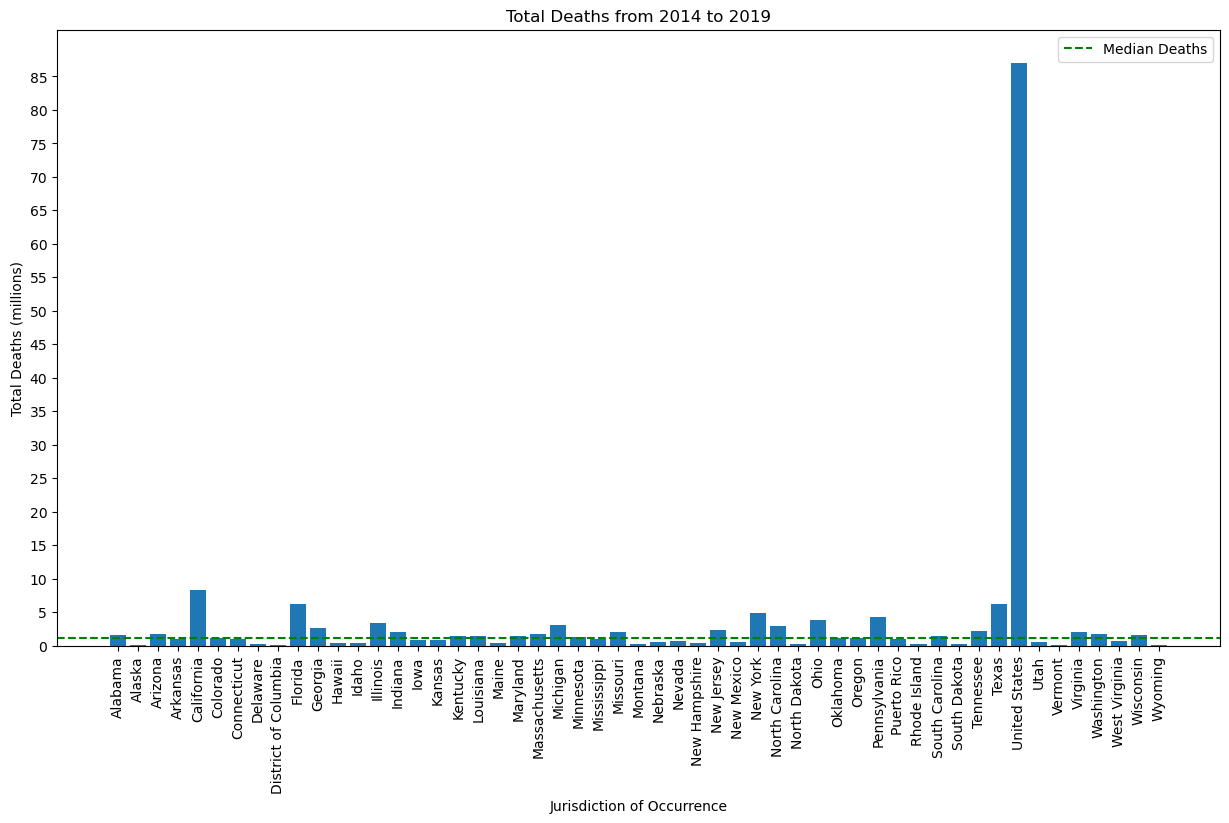

In [23]:
# EDA

# Yearly Deaths barplot by States

# Adjust the figure size as needed
plt.figure(figsize=(15, 8))

# Remove non-integer values from Total Deaths
YearlyDeaths_clean = YearlyDeaths.dropna()

#Calculating Total Deaths from year 2014 to 2019
Final_Death_cal = YearlyDeaths_clean.groupby('Jurisdiction of Occurrence')['Total Deaths'].sum().to_frame(name='Grand Total of Deaths').reset_index()
#print(Final_Death_cal.head(5))
#print(Final_Death_cal[Final_Death_cal['Jurisdiction of Occurrence']=='United States'])


# Plotting barplot
plt.bar(Final_Death_cal['Jurisdiction of Occurrence'], Final_Death_cal['Grand Total of Deaths'] / 10**6)

# Set labels and title
plt.xlabel('Jurisdiction of Occurrence')
plt.ylabel('Total Deaths (millions)')
plt.title('Total Deaths from 2014 to 2019')

# Adding deaths median line
plt.axhline(Final_Death_cal['Grand Total of Deaths'].median() / 10**6, color='Green', linestyle='--', label='Median Deaths')

# Add legend
plt.legend()

# Set X labels 90 degrees for better visibility
plt.xticks(rotation=90)

# Limiting Y values
plt.ylim(0, max(Final_Death_cal['Grand Total of Deaths'] / 10**6) + 5)

# Setting Y ticks
plt.yticks(range(0, int(max(Final_Death_cal['Grand Total of Deaths'] / 10**6)) + 1, 5))

plt.show()


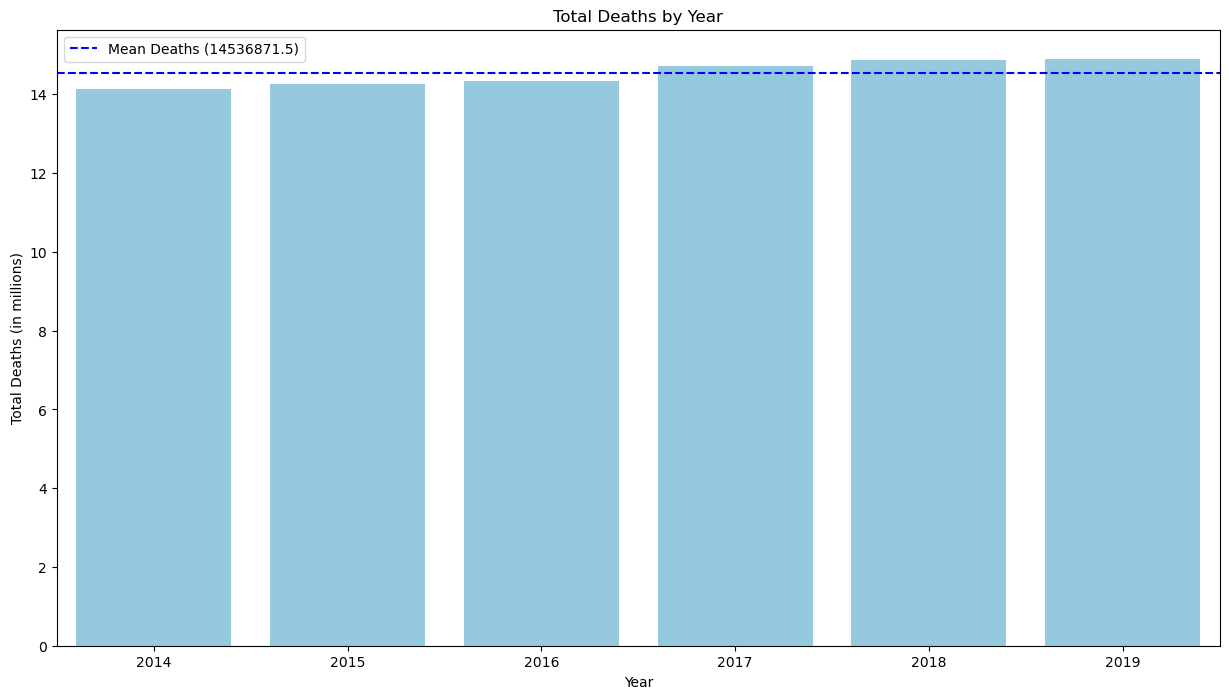

In [7]:
# Create a DataFrame from the data
YearlyDeaths = pd.DataFrame(YearlyDeaths)

# Group the data by 'MMWR Year' and calculate the sum of 'Total Deaths' for each year
yearly_deaths = YearlyDeaths.groupby('MMWR Year')['Total Deaths'].sum().reset_index()

# Calculate the mean deaths
mean_deaths = yearly_deaths['Total Deaths'].mean()

# Increase Y values by 10 million
yearly_deaths['Total Deaths'] = yearly_deaths['Total Deaths'] / 10**6

# adjust figure size
plt.figure(figsize=(15, 8))

# Plotting barplot using Seaborn
sns.barplot(data=yearly_deaths, x='MMWR Year', y='Total Deaths', color='skyblue')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Deaths (in millions)')
plt.title('Total Deaths by Year')

# Adding deaths mean line
plt.axhline(mean_deaths / 10**6, color='Blue', linestyle='--', label=f'Mean Deaths ({mean_deaths})')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [8]:
#Data Engineering
#How many deaths per 100,000 in the respective states

#Read population dataset
State_popu = pd.read_excel('documents/python/nst-est2019-01.xlsx')
print('\nColumns of State population dataframe:')
print(State_popu.columns)
print('\nHead of the Dataframe')
print(State_popu.head(5))

#Delete Estimate base column as it's not useful in the analysis
State_popu = State_popu.drop(columns=['Census','Estimates Base', 2010, 2011, 2012, 2013])


print('\nUpdated dataframe')
print(State_popu.head(5))


# Merge and verify the dataset

Death_Popu = YearlyDeaths.merge(State_popu,
                                left_on="Jurisdiction of Occurrence",
                                right_on="Demographics", how='left',
                                suffixes=('_Deaths', '_Population'))
print(Death_Popu.columns)

"""
 
# Calculate deaths per 100000 for each year
for year in range(2014, 2020):
    Death_Popu[f'{year}_Deaths_per_100000'] = round((Death_Popu[f'{year}_Deaths'] / Death_Popu[f'{year}_Population'])
                                                    * 100000)

# Display the resulting dataframe with deaths per 100,000 for each year
print(Population_deaths)
"""


Columns of State population dataframe:
Index([  'Demographics',         'Census', 'Estimates Base',             2010,
                   2011,             2012,             2013,             2014,
                   2015,             2016,             2017,             2018,
                   2019],
      dtype='object')

Head of the Dataframe
    Demographics     Census  Estimates Base       2010       2011       2012  \
0  United States  308745538       308758105  309321666  311556874  313830990   
1        Alabama    4779736         4780125    4785437    4799069    4815588   
2         Alaska     710231          710249     713910     722128     730443   
3        Arizona    6392017         6392288    6407172    6472643    6554978   
4       Arkansas    2915918         2916031    2921964    2940667    2952164   

        2013       2014       2015       2016       2017       2018       2019  
0  315993715  318301008  320635163  322941311  324985539  326687501  328239523  
1    4830

"\n \n# Calculate deaths per 100000 for each year\nfor year in range(2014, 2020):\n    Death_Popu[f'{year}_Deaths_per_100000'] = round((Death_Popu[f'{year}_Deaths'] / Death_Popu[f'{year}_Population'])\n                                                    * 100000)\n\n# Display the resulting dataframe with deaths per 100,000 for each year\nprint(Population_deaths)\n"